In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install lime
!pip install -U pyYAML

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 275 kB 5.3 MB/s 
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283857 sha256=2cbc30fb8de87b63f663f7500ca5a21883ba642bef9095bc15bba8553b6c19ee
  Stored in directory: /root/.cache/pip/wheels/ca/cb/e5/ac701e12d365a08917bf4c6171c0961bc880a8181359c66aa7
Successfully built lime
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 596 kB 4.9 MB/s 
  Attempting uninstall: pyYAML
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lime
import yaml
from keras.models import load_model
from lime import lime_image
from skimage.segmentation import mark_boundaries
from skimage.transform import resize
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array



In [4]:
cfg = yaml.full_load(open("/content/drive/MyDrive/FP/config.yml", 'r'))

In [5]:
xception = load_model(cfg['PATHS']['XCEPTION'])

In [11]:
test_data = pd.read_csv(cfg['PATHS']['TEST_SET'])
sample_images = test_data.sample(n=2, random_state=1)["filename"]

In [12]:
def visualise_explanations(path, model):
  classes = ["Covid","Normal","Viral Pneumonia"]
  img = load_img(path)
  fig, ax = plt.subplots(1, 3, figsize=(20, 20))
  ax[0].imshow(plt.imread(path), cmap='gray')

  img = image_resizing(img)
  probs = model.predict(img)
  predictic_class = classes[np.argmax(probs)]
  probalility = max(probs)
  
  temp_1, mask_1, temp_2, mask_2 = get_explanations(img, model)
  ax[1].imshow(mark_boundaries(temp_1 / 2 + 0.5, mask_1))
  ax[2].imshow(mark_boundaries(temp_2 / 2 + 0.5, mask_2))

  return predictic_class , probalility


In [13]:
def image_resizing(img):
  img_a = img_to_array(img)
  img_a = img_a/255
  img = resize(img_a,(224, 224),anti_aliasing=True)
  img = img.reshape(1, 224, 224, 3)

  return img

In [14]:
def get_explanations(img, model):
  explainer = lime_image.LimeImageExplainer()
  img_l = img.reshape(224, 224, 3)
  explanation = explainer.explain_instance(img_l.astype('double'), model.predict, top_labels=5, hide_color=0, num_samples=1000)
  temp_1, mask_1 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=True)
  temp_2, mask_2 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)

  return temp_1, mask_1, temp_2, mask_2

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

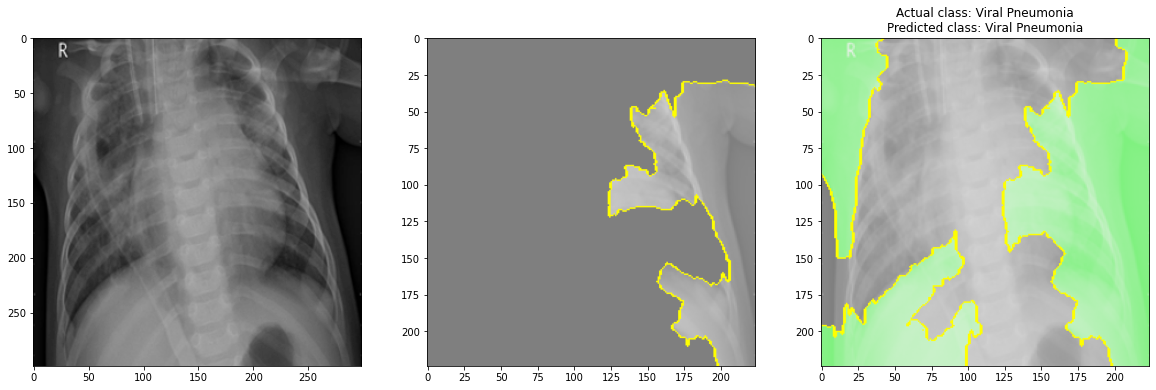

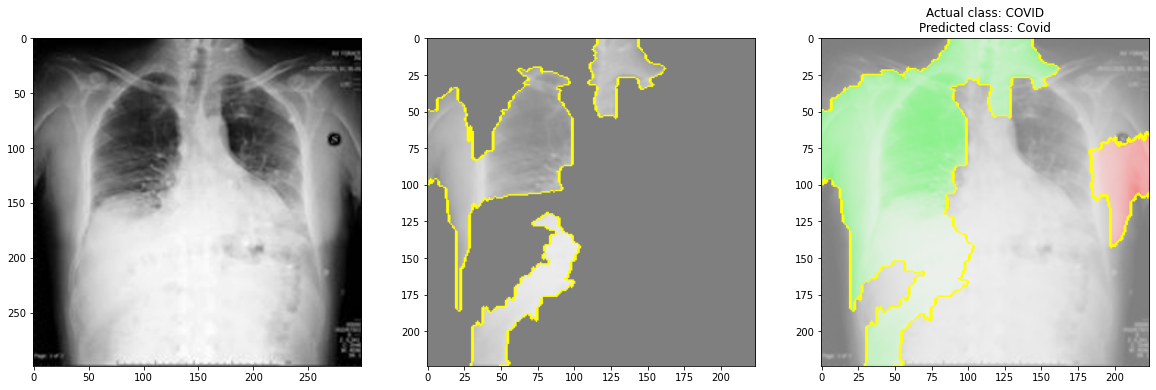

In [15]:
for i,path in enumerate(sample_images) :
    actual_class = path.split("/")[-1].split("-")[0]
    predicted_class, probalility = visualise_explanations(path, xception)
    plt.title(f"Actual class: {actual_class}\nPredicted class: {predicted_class}")